In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel

In [77]:
#loading the data
News=[]
Type=[]

path="/content/drive/MyDrive/NMDS/Articles"
folders=["business","entertainment","politics","sport","tech"]
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)

In [78]:
#wrinting data to csv format
data={'Description':News,'Class':Type}
df = pd.DataFrame(data)
df.to_csv('articles.csv',index=False)

In [79]:
df= pd.read_csv('articles.csv')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  2225 non-null   object
 1   Class        2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [81]:
df.head()

Description     Class
0  b'Ford gains from finance not cars\n\nFord, th...  business
1  b"Making your office work for you\n\nOur missi...  business
2  b'Business fears over sluggish EU economy\n\nA...  business
3  b'Call centre users \'lose patience\'\n\nCusto...  business
4  b'Share boost for feud-hit Reliance\n\nThe boa...  business

In [82]:
df["Class"].value_counts()

Class
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [83]:
df.describe(include='object')

Description  Class
count                                                2225   2225
unique                                               2127      5
top     b'Latest Opera browser gets vocal\n\nNet brows...  sport
freq                                                    2    511

In [84]:
#removing duplicates
print(len(df[df['Description'].duplicated()]))
df=df.drop_duplicates('Description')

98


In [85]:
print(df.Class.unique())

['business' 'entertainment' 'politics' 'sport' 'tech']


**Feature engineering**

In [86]:
#length of the news
df['length']=df.Description.str.len()

In [87]:
#function to count the number of words in the article
def word_count(article):
  return len(article.split(" "))

In [88]:
# Getting word count of each article
df['word_count']=df['Description'].apply(word_count)

In [89]:
df.describe()

length   word_count
count   2127.000000  2127.000000
mean    2288.550071   379.444758
std     1393.870309   238.261401
min      512.000000    87.000000
25%     1460.000000   242.000000
50%     1987.000000   327.000000
75%     2825.500000   465.000000
max    25670.000000  4377.000000

In [90]:
#Total number of words present in the whole corpus
Total_words=sum(df['word_count'])
Total_words

807079

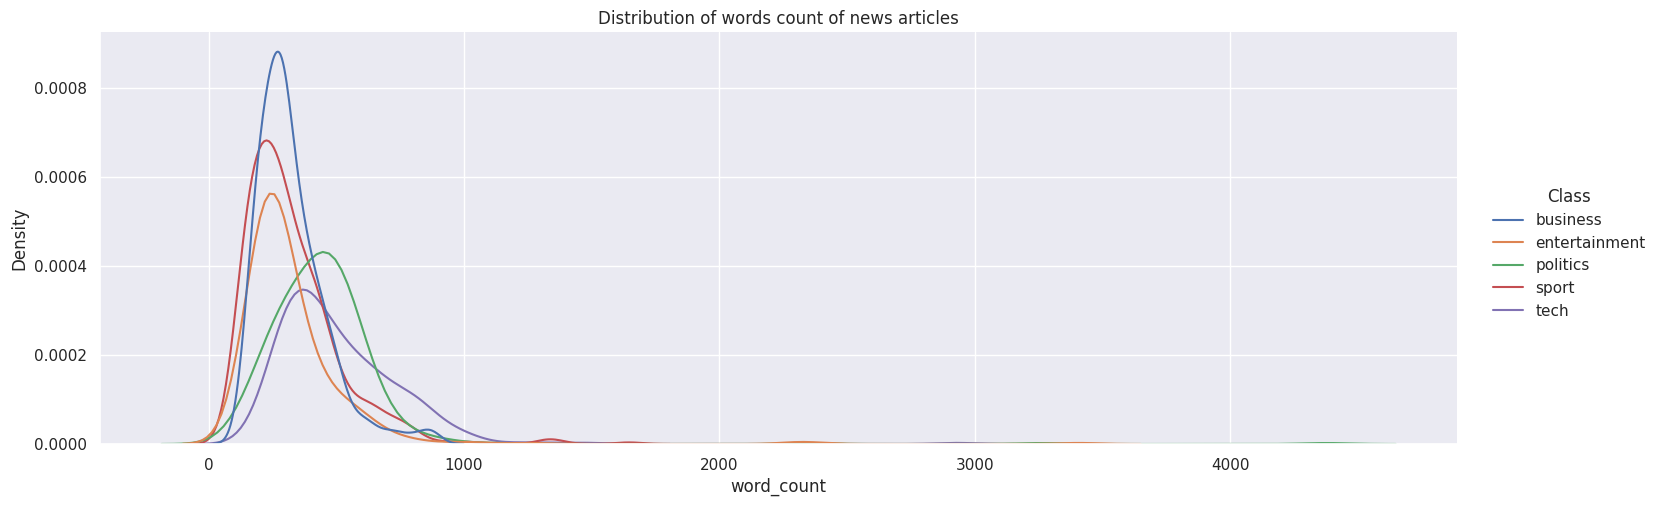

In [91]:
sns.displot(df, x="word_count", hue="Class", kind="kde",height=5,aspect =3 ).set(title='Distribution of words count of news articles');

<ipython-input-92-5571d1c617d1>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig=sns.distplot(x=df_article['word_count'])
<ipython-input-92-5571d1c617d1>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig=sns.distplot(x=df_article['word_count'])
<ipython-input-92-5571d1c617d1>:6: UserWarning: 

`distplot` is a depr

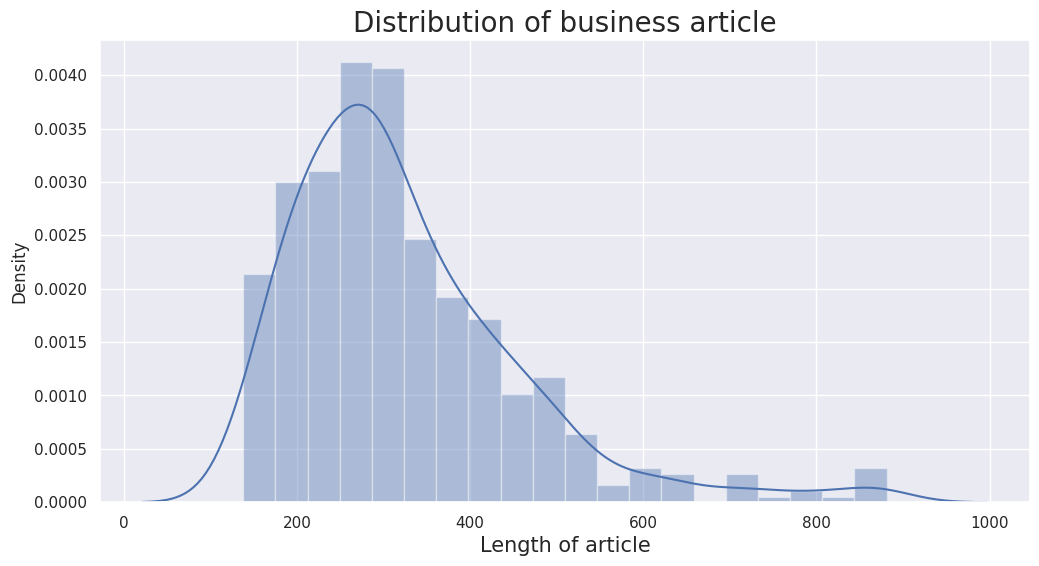

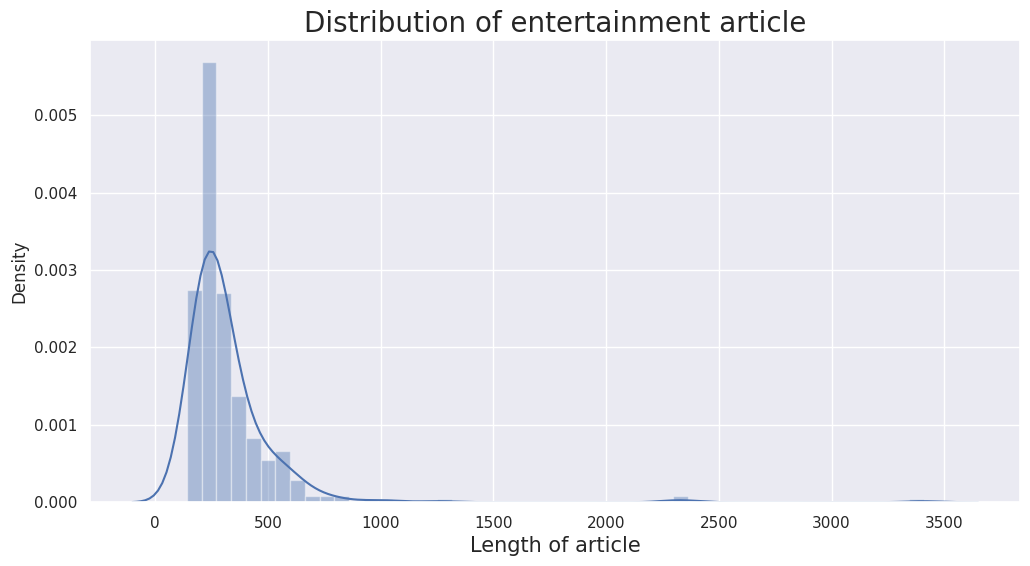

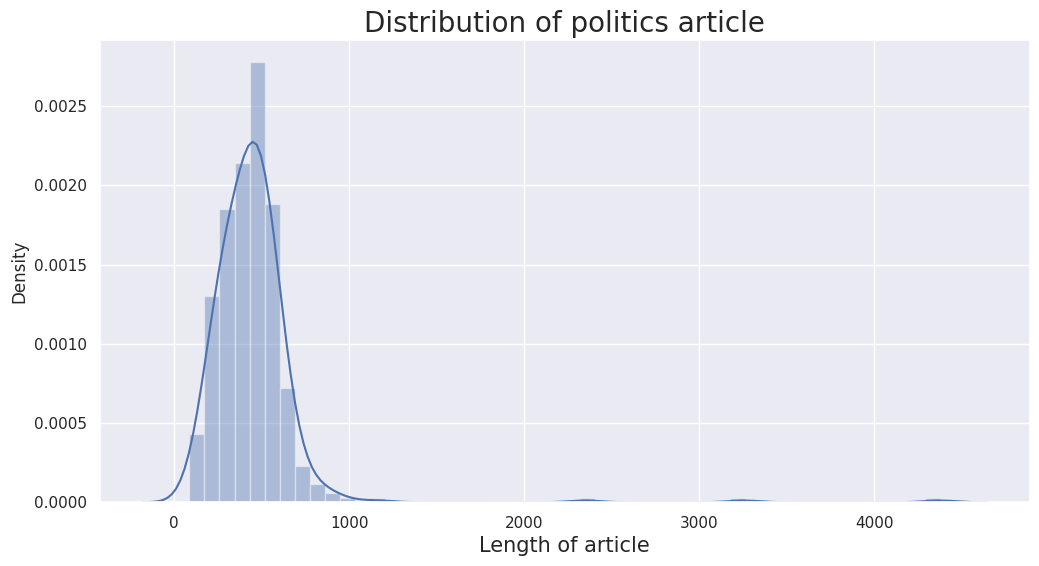

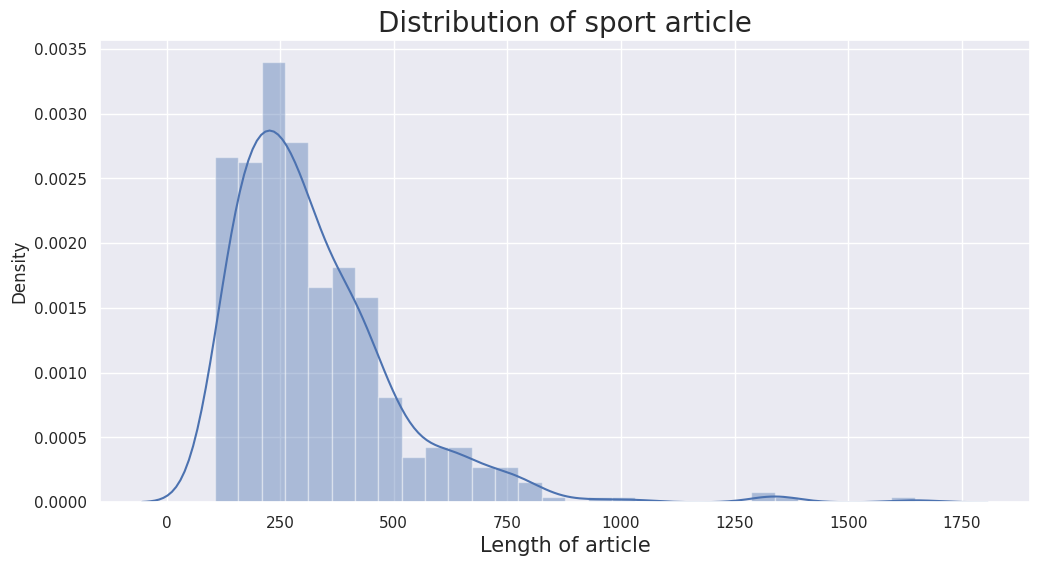

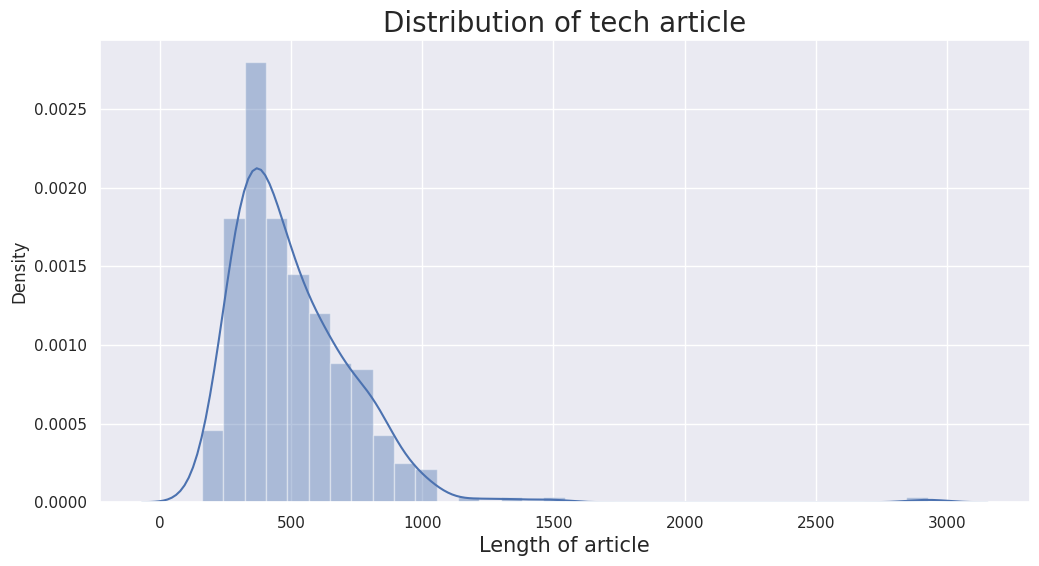

In [92]:
#Distribution of different types of articles
types_article=list(df['Class'].unique())
for article in types_article:
  df_article=df[df['Class']==article]
  plt.figure(figsize=(12,6))
  fig=sns.distplot(x=df_article['word_count'])
  fig.set_title(f'Distribution of {article} article',size=20)
  fig.set_xlabel('Length of article',size=15)

In [93]:
#copying the original data
corpus_df=df.copy(deep=True)

In [94]:
#Function to perform cleaning or preprocessing of articles
def cleaning(text):
  cleaned_text = text.replace('\\n'," ")                              # removal of new line symbol \n

  cleaned_text = re.sub("[^a-zA-Z]"," ",cleaned_text)                 # removal of all the punctuations,special character, numbers

  cleaned_text = cleaned_text.lower()                                 # converting to lower case

  cleaned_text = re.sub(r'\s+'," ",cleaned_text)                      # Removal of additional white space

  return cleaned_text

In [95]:
corpus_df['Description']=corpus_df['Description'].apply(cleaning)

In [96]:
#Word Count after basic cleaning
corpus_df['wc_after_cleaning']=corpus_df['Description'].apply(word_count)

In [97]:
corpus_df.head()

Description     Class  length  \
0  b ford gains from finance not cars ford the us...  business    2241   
1  b making your office work for you our mission ...  business    5167   
2  b business fears over sluggish eu economy as e...  business    4627   
3  b call centre users lose patience customers tr...  business    3882   
4  b share boost for feud hit reliance the board ...  business     904   

   word_count  wc_after_cleaning  
0         362                371  
1         875                895  
2         816                810  
3         653                643  
4         144                151

In [98]:
#Lemmatization
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
def lemmatize_word(text):
    word_list = word_tokenize(text)
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    return ' '.join(word_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [99]:
#Applying lemmatization
corpus_df['Description']=corpus_df['Description'].apply(lemmatize_word)

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus')]

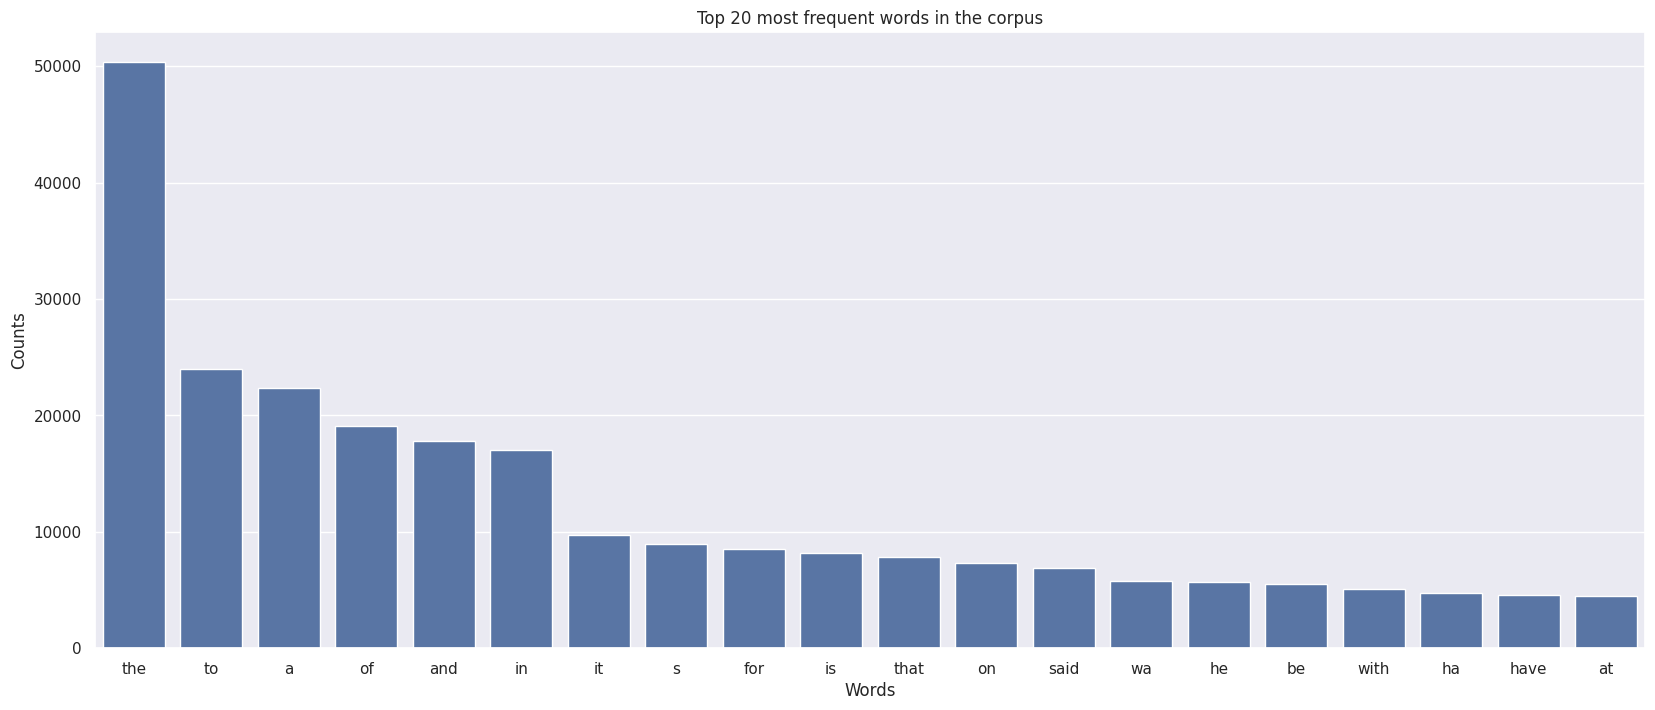

In [100]:
#Top 20 most frequent words in the corpus
Top_20_freq = pd.Series(' '.join(corpus_df['Description']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus')

In [101]:
#Removing short length words ( length less than 3)
def short_length(text):
  return (' '.join([wds for wds in text.split() if len(wds)>2]))

corpus_df['Description']=corpus_df['Description'].apply(short_length)

In [102]:
#Stopwords
# list of stopwords from nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
len(all_stopwords)

412

In [104]:
#Removal of Stopwords
corpus_df['Description']=corpus_df['Description'].apply(stop_words)

In [105]:
# word count after removing the stopwords
corpus_df['after_stop']=corpus_df['Description'].apply(word_count)

In [106]:
corpus_df.head()

Description     Class  length  \
0  ford gain finance car ford car company reporte...  business    2241   
1  making office work mission brighten working li...  business    5167   
2  business fear sluggish economy european leader...  business    4627   
3  centre user lose patience customer trying cent...  business    3882   
4  share boost feud hit reliance board indian con...  business     904   

   word_count  wc_after_cleaning  after_stop  
0         362                371         202  
1         875                895         411  
2         816                810         358  
3         653                643         288  
4         144                151          77

In [107]:
#removal of non-contextual words
add_stopwords= ['said','told','called','use','know','came','based','way','added','including','got']

In [108]:
#Function to remove additional stopwords
def remove_add_stopwords(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in add_stopwords]
  return " ".join(text)

In [109]:
#Removing addtional stopwords according to use case
corpus_df['Description']=corpus_df['Description'].apply(remove_add_stopwords)

In [110]:
# word count after removing the additional stopwords
corpus_df['wc_rem_stopword']=corpus_df['Description'].apply(word_count)

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus After stopword removal')]

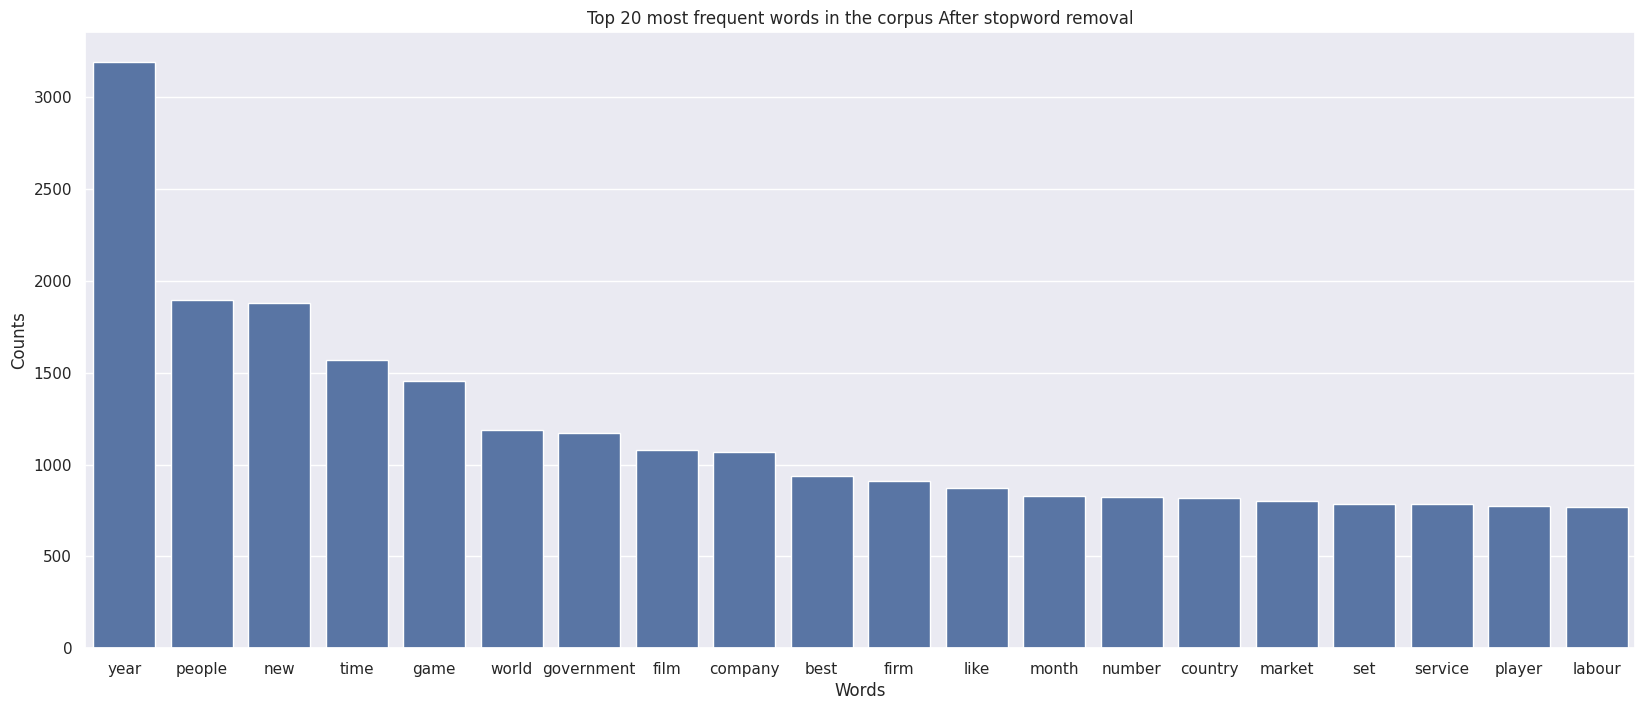

In [111]:
#Top 20 most frequent words in the corpus After stopword removal
Top_20_freq = pd.Series(' '.join(corpus_df['Description']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus After stopword removal')

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_gram(corpus, ngram, n=20):

    '''
    This functions takes entire corpus and returns list of tuple in  pair words and number of its occurence.
    '''
    # creates instance of count vectorizer for n-grams
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)

    # returns sparse matrix of index as documents and columns as Bow as features
    bag_of_words = vec.transform(corpus)

    # returns 2D array with count of features in corpus
    sum_words = bag_of_words.sum(axis=0)

    # returns list of tuples with text,counts pair
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # sort the list of tuples by its number of occurence
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # returns list of tuples top n words
    return words_freq[:n]

[Text(0.5, 1.0, 'Top 20 bigram words')]

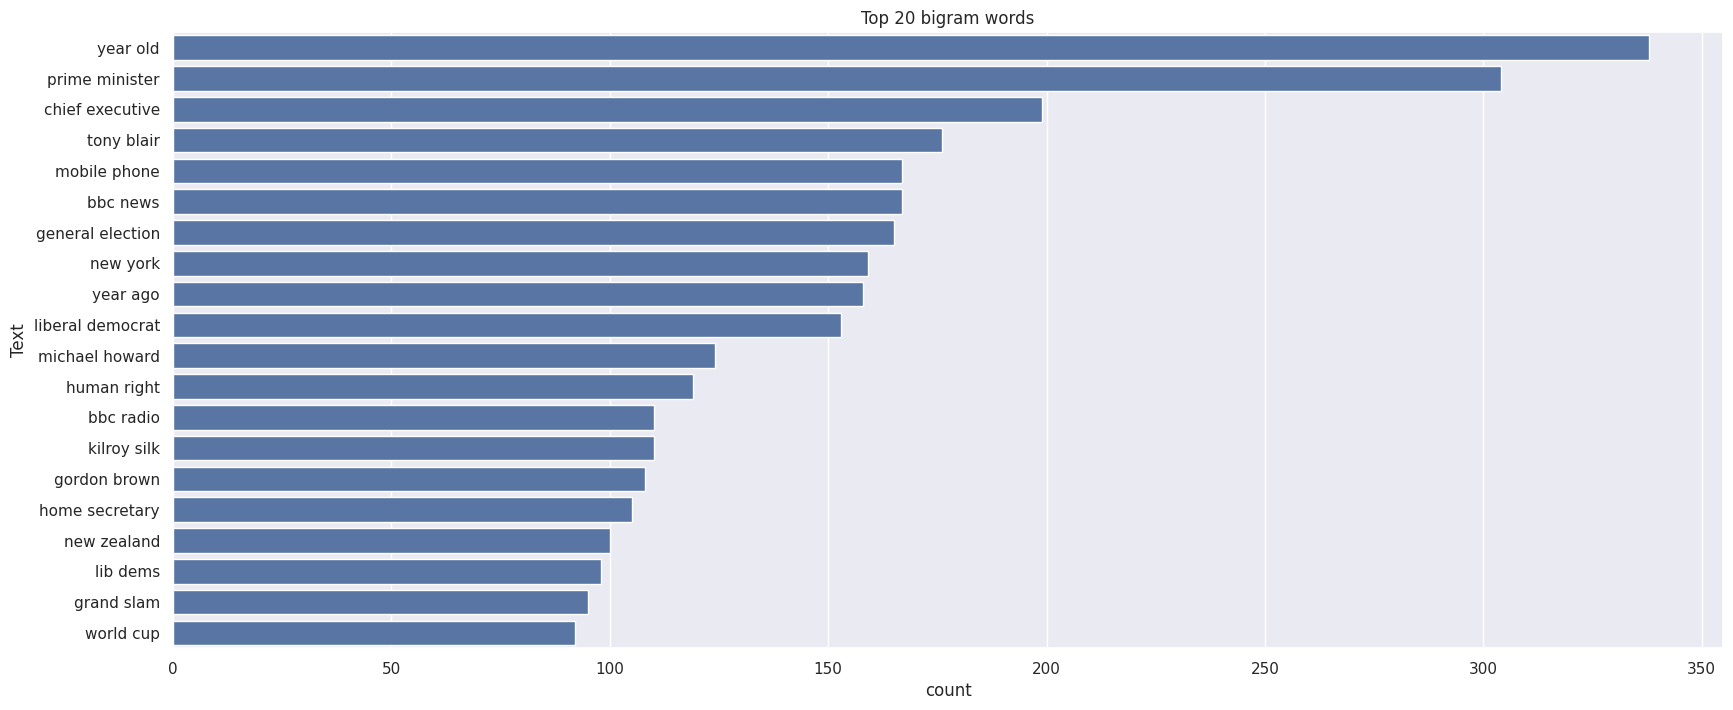

In [113]:
# get top 20 bigram words using function
common_words = get_top_n_gram(corpus_df['Description'],ngram=2)

# creates dataframe from list of tuples
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df1,ax=ax).set(title='Top 20 bigram words')

[Text(0.5, 1.0, 'Top 20 trigram words')]

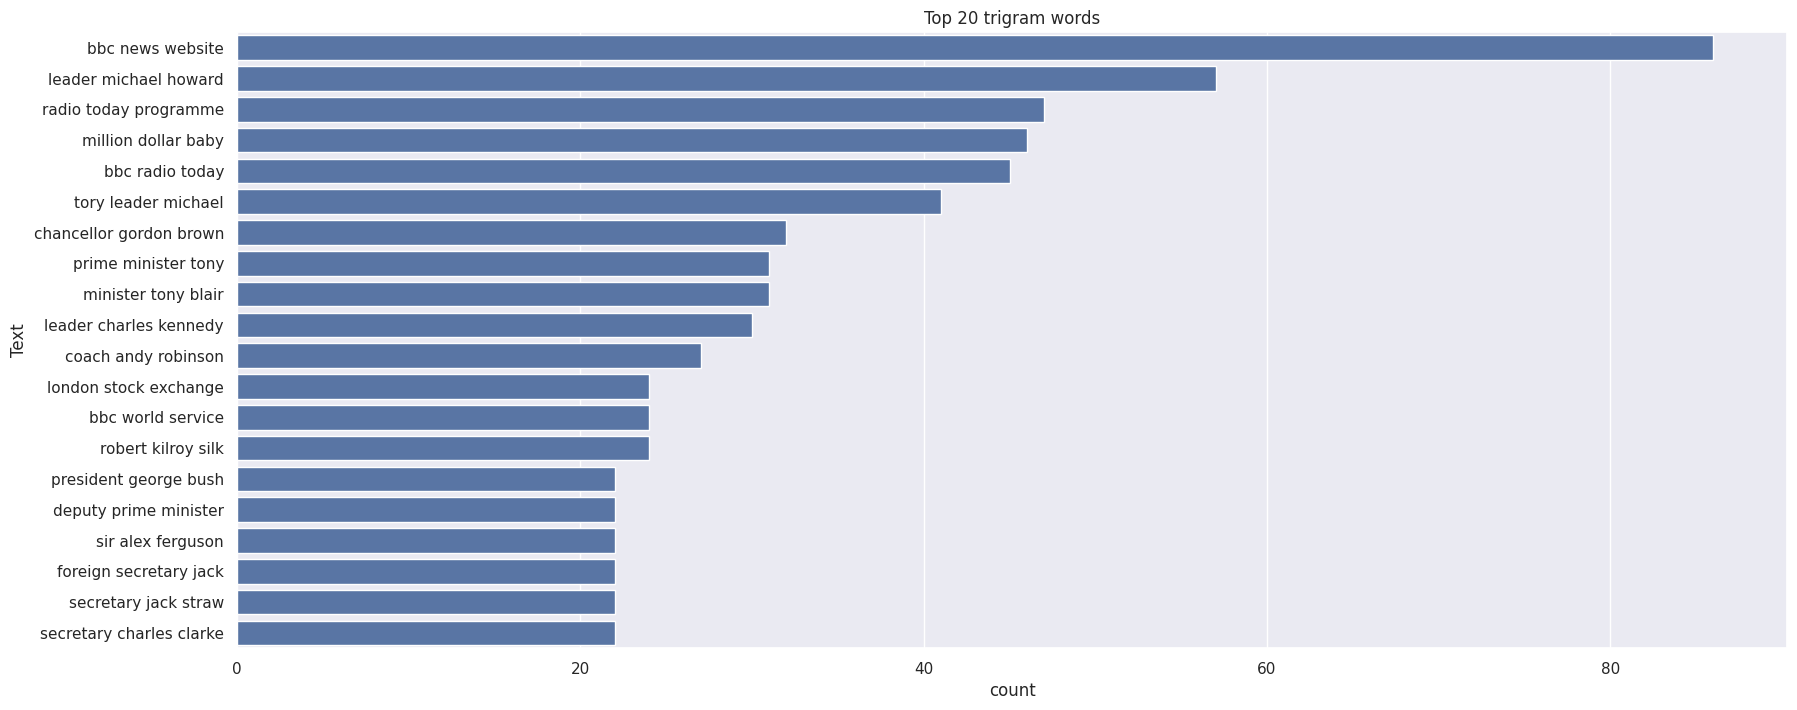

In [114]:
# get top 20 trigram words using function
common_words = get_top_n_gram(corpus_df['Description'],ngram=3)

# creates dataframe from list of tuples
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df2,ax=ax).set(title='Top 20 trigram words')

In [115]:
#Data reduction
after_preprocess=corpus_df['wc_rem_stopword'].sum()
after_preprocess

data_reduce=(after_preprocess/Total_words)*100
data_reduce

48.56823185834349

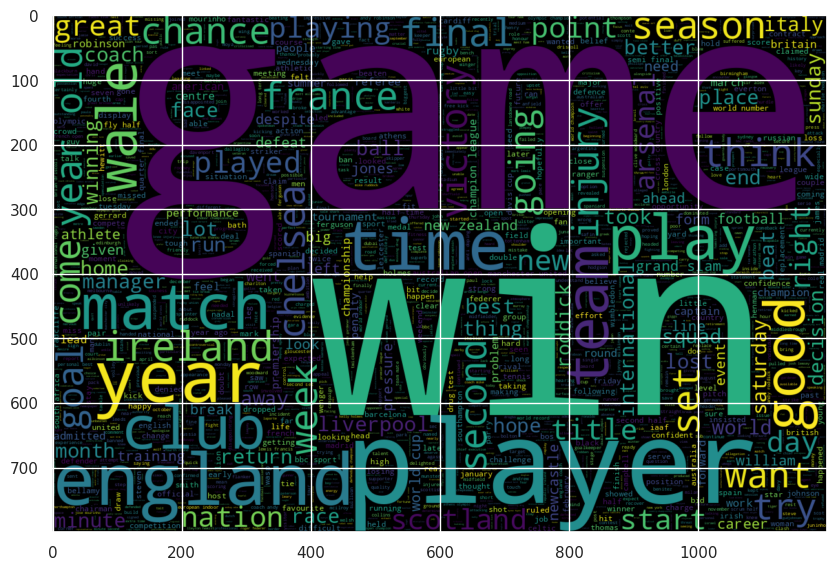

In [116]:
world = corpus_df.Description[df.Class[df.Class=="sport"].index]
plt.figure(figsize = (10,15)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear');

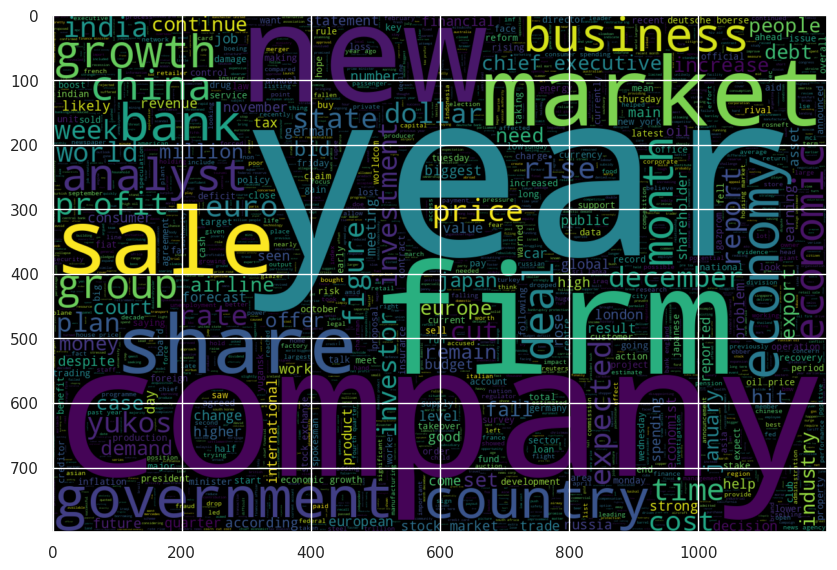

In [117]:
world = corpus_df.Description[df.Class[df.Class=="business"].index]
plt.figure(figsize = (10,15)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear');

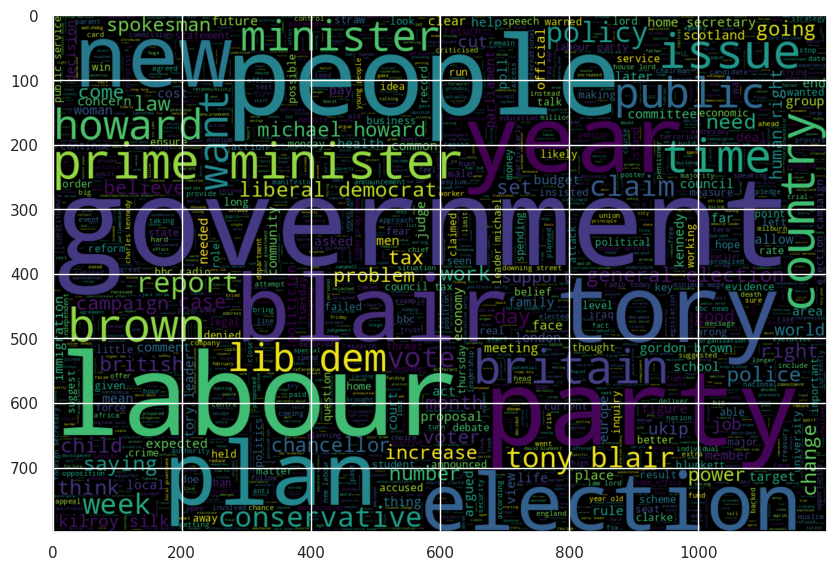

In [118]:
world = corpus_df.Description[df.Class[df.Class=="politics"].index]
plt.figure(figsize = (10,15)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear');

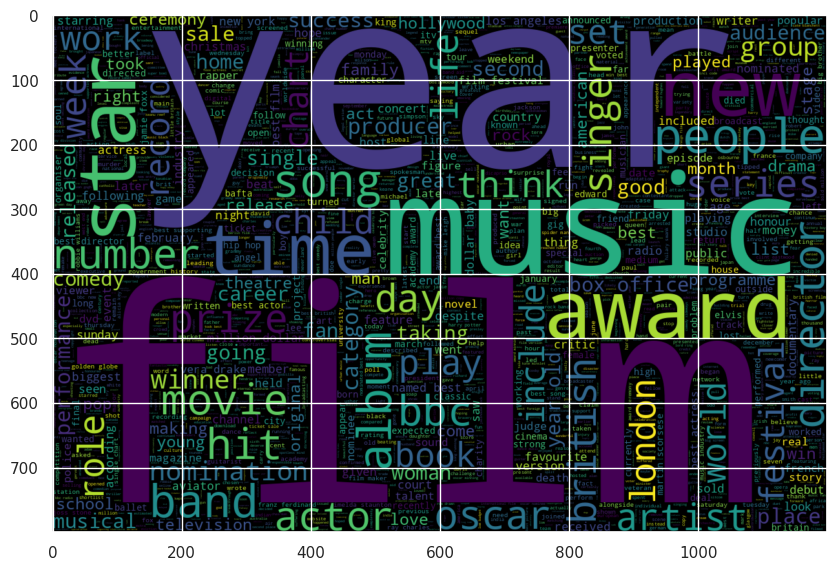

In [119]:
world = corpus_df.Description[df.Class[df.Class=="entertainment"].index]
plt.figure(figsize = (10,15)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear');

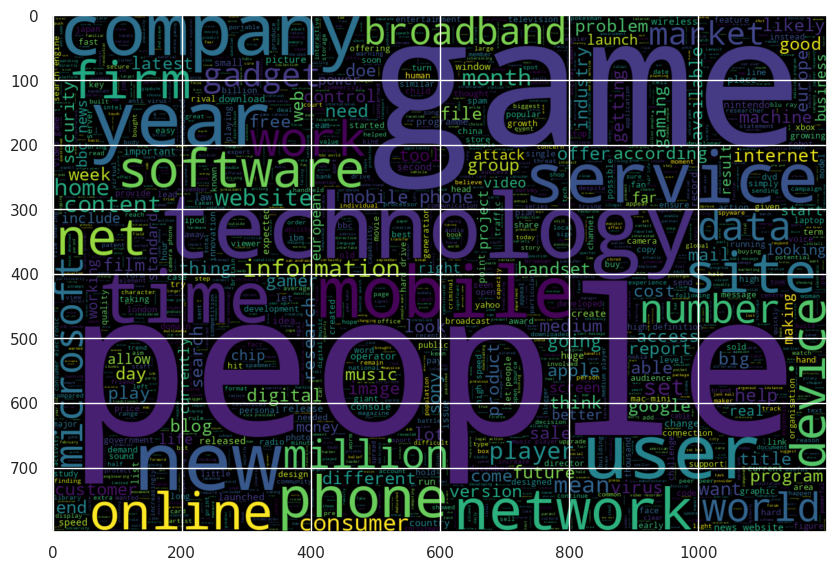

In [120]:
world = corpus_df.Description[df.Class[df.Class=="tech"].index]
plt.figure(figsize = (10,15)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear');

**TFIDF - LDA**

In [141]:
#Tf-Idf vectoriser
vectorizer = TfidfVectorizer(min_df=0.03)
document_term_matrix = vectorizer.fit_transform(corpus_df['Description'])

In [142]:
#Shape of document term matrix
document_term_matrix.shape

(2127, 947)

In [129]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(3,8))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 3}
Best log likelihood Score for the LDA model -22379.72743990671
LDA model Perplexity on train data 1185.8670744137871


In [130]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5,max_iter=1000,random_state=42, n_jobs=-1)
lda.fit(document_term_matrix)

LatentDirichletAllocation(max_iter=1000, n_components=5, n_jobs=-1,
                          random_state=42)

In [132]:
lda.perplexity(document_term_matrix)

1447.6171746022642

In [131]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(2127, 5)
[[0.02930483 0.49348748 0.41895918 0.02902529 0.02922322]
 [0.02248975 0.91093888 0.02209097 0.02223724 0.02224316]
 [0.115617   0.60029472 0.24330898 0.01968773 0.02109156]
 ...
 [0.02717414 0.89175269 0.02695134 0.02706288 0.02705895]
 [0.02695045 0.84525563 0.02670209 0.07412296 0.02696887]
 [0.03155223 0.87462624 0.03156061 0.03110789 0.03115302]]


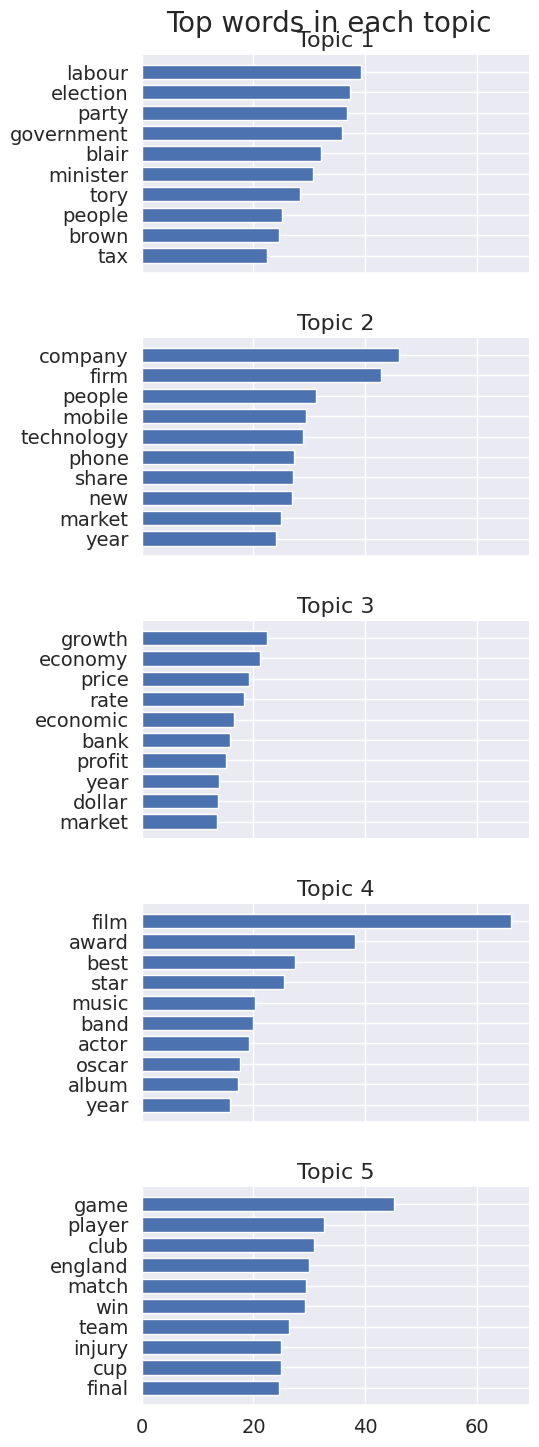

In [133]:
import matplotlib.pyplot as plt

def plot_top_words(lda_model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=len(lda_model.components_), ncols=1, figsize=(5, 3 * len(lda_model.components_)), sharex=True)
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)


**TFIDF-NMF**

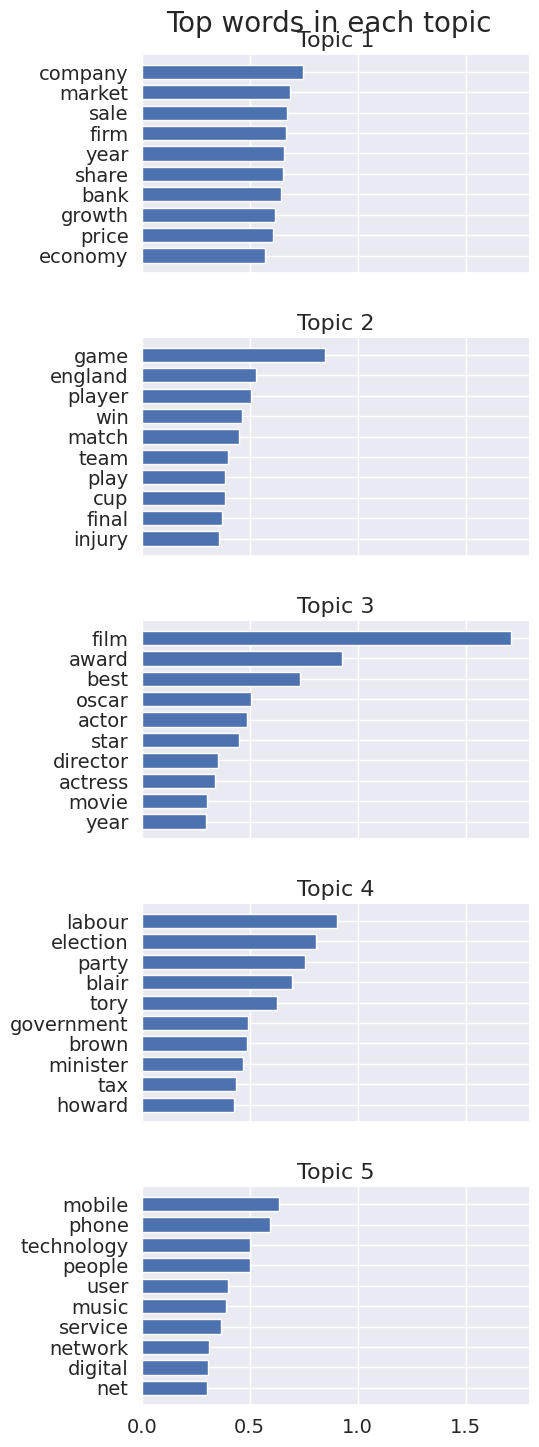

In [135]:
from sklearn.decomposition import NMF

# Assuming document_term_matrix is your document-term matrix obtained from TfidfVectorizer

# Specify the number of topics
num_topics = 5 # You can adjust this as needed

# Initialize NMF model
nmf_model = NMF(n_components=num_topics, random_state=33)

# Fit the model to your document-term matrix
nmf_model.fit(document_term_matrix)

# Get the topic-word matrix
topic_word_matrix = nmf_model.components_

# Get the document-topic matrix
document_topic_matrix = nmf_model.transform(document_term_matrix)

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=model.components_.shape[0], ncols=1, figsize=(5, 3 * model.components_.shape[0]), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

# Assuming nmf_model is your trained NMF model
# Assuming feature_names are the words in your vocabulary obtained from TfidfVectorizer
n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()  # Assuming you have already fitted TfidfVectorizer
plot_top_words(nmf_model, feature_names, n_top_words)

**TFIDF-LSA(SVD)**

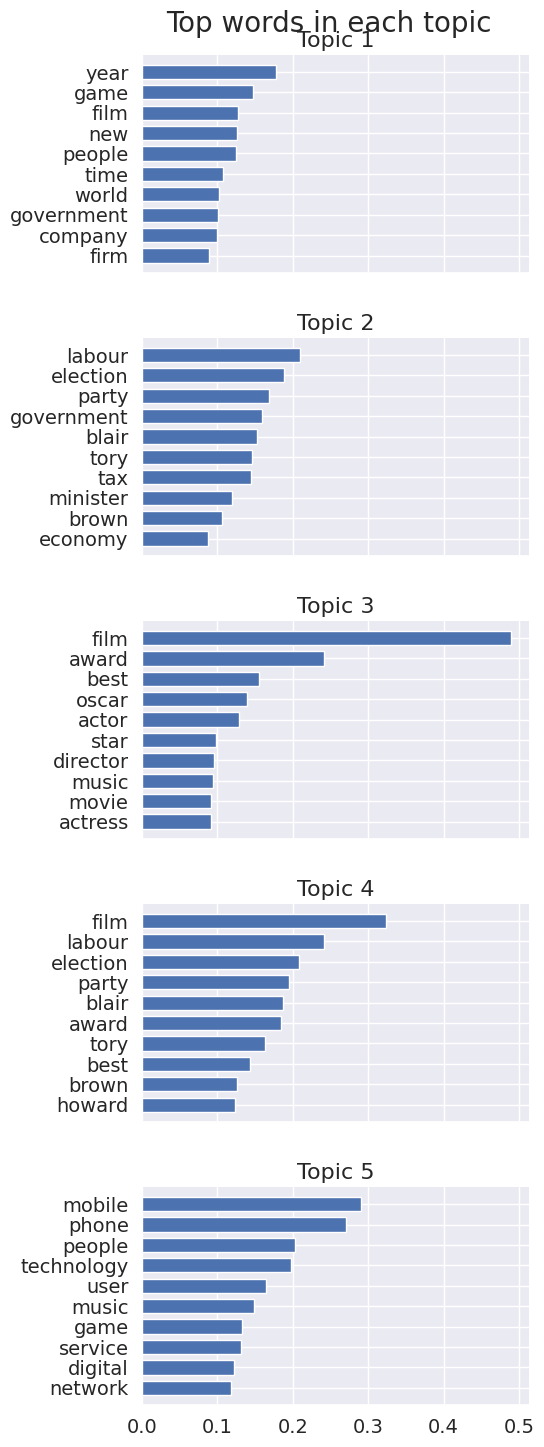

In [137]:
from sklearn.decomposition import TruncatedSVD

# Assuming document_term_matrix is your document-term matrix obtained from TfidfVectorizer

# Specify the number of topics
num_topics = 5  # You can adjust this as needed

# Initialize LSA model with SVD
lsa_model = TruncatedSVD(n_components=num_topics, random_state=33)

# Fit the model to your document-term matrix
lsa_model.fit(document_term_matrix)

# Get the topic-word matrix
topic_word_matrix = lsa_model.components_

# Get the document-topic matrix
document_topic_matrix = lsa_model.transform(document_term_matrix)

# Now you have obtained the topic-word matrix and document-topic matrix

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=model.components_.shape[0], ncols=1, figsize=(5, 3 * model.components_.shape[0]), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

# Assuming lsa_model is your trained LSA model
# Assuming feature_names are the words in your vocabulary obtained from TfidfVectorizer
n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()  # Assuming you have already fitted TfidfVectorizer
plot_top_words(lsa_model, feature_names, n_top_words)

**Count-LDA**

In [143]:
#Count vectoriser
vectorizer = CountVectorizer(max_features=1000)
document_term_matrix = vectorizer.fit_transform(corpus_df['Description'])

In [149]:
#Shape of document term matrix
document_term_matrix.shape

(2127, 1000)

In [147]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(3,8))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -311280.4176331502
LDA model Perplexity on train data 586.8316545861228


In [150]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5,max_iter=1000,random_state=42, n_jobs=-1)
lda.fit(document_term_matrix)

LatentDirichletAllocation(max_iter=1000, n_components=5, n_jobs=-1,
                          random_state=42)

In [151]:
lda.perplexity(document_term_matrix)

549.1233236003956

In [152]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(2127, 5)
[[1.65093524e-03 9.93438759e-01 1.63070181e-03 1.63377462e-03
  1.64582927e-03]
 [6.93966626e-01 1.12069246e-01 1.25106135e-03 1.91459773e-01
  1.25329376e-03]
 [8.36266855e-02 6.72268705e-01 9.78554032e-04 1.51443440e-01
  9.16826150e-02]
 ...
 [8.61693782e-01 1.13435621e-01 1.71930126e-03 2.14141920e-02
  1.73710396e-03]
 [7.84022854e-01 1.75263375e-01 3.71976401e-02 1.76288580e-03
  1.75324477e-03]
 [4.73445117e-01 3.68617665e-01 2.07160571e-03 1.53801787e-01
  2.06382533e-03]]


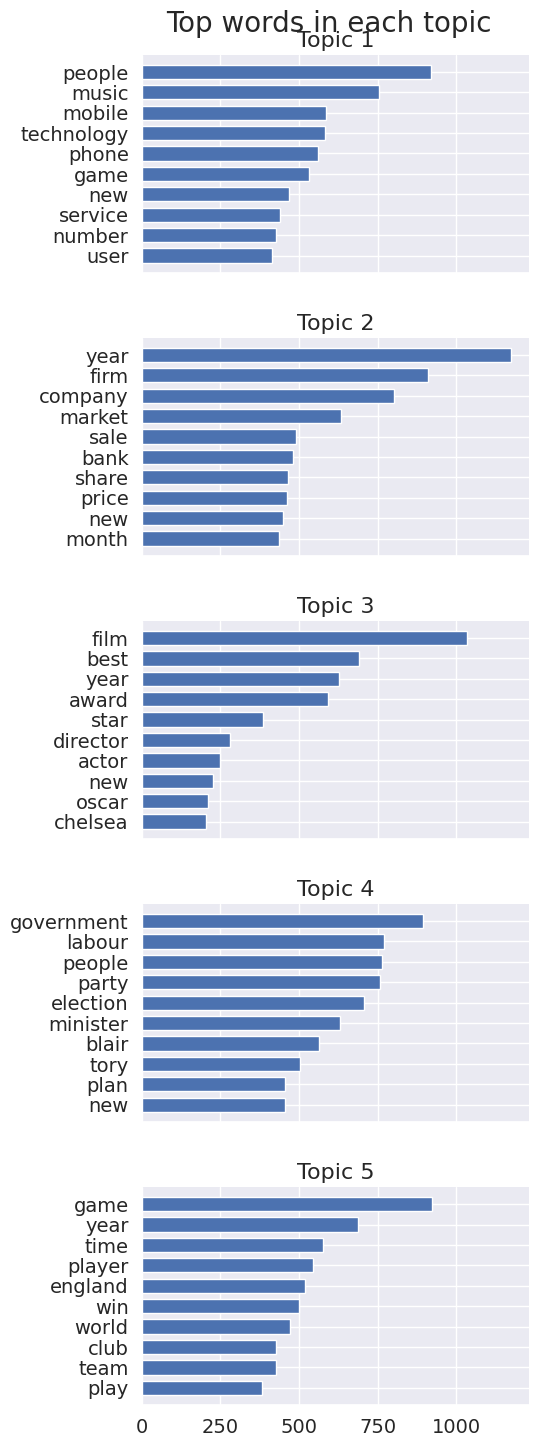

In [153]:
def plot_top_words(lda_model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=len(lda_model.components_), ncols=1, figsize=(5, 3 * len(lda_model.components_)), sharex=True)
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)

In [190]:
df["Description"][2222]

'b\'Yahoo moves into desktop search\\n\\nInternet giant Yahoo has launched software to allow people to search e-mail and other files on their PCs.\\n\\nThe firm is following in the footsteps of Microsoft, Google and Ask Jeeves, which have offered similar services. Search has become a lucrative and hotly-contested area of expansion for net firms, looking to extend loyalty beyond the web. With hard drives providing bigger storage, users could need more help to locate important files, such as photos.\\n\\nThe desktop search technology has been licensed from a US-based firm X1 Technologies. It is designed to work alongside Microsoft\\\'s Outlook and Outlook Express e-mail programs. Searching e-mail effectively is becoming increasingly important, especially as the amount of spam increases. According to research from message analysts the Radicati Group, up to 45% of businesses\\\' critical information is stored in e-mail and attachments. Yahoo\\\'s software can also work separately on the de

In [196]:
# Preprocess the new text (replace this with your preprocessing steps)
new_text = df["Description"][2222]

# Vectorize the preprocessed text using the same vectorizer used during training
vectorized_text = vectorizer.transform([new_text])

# Infer topic distribution for the new text using the trained LDA model
topic_distribution = lda_model.transform(vectorized_text)

# Get topic percentages
topic_percentages = topic_distribution / topic_distribution.sum(axis=1)[:, np.newaxis]

# Display the topic percentages
print("Topic Percentages:")
for i, percentage in enumerate(topic_percentages[0]):
    print(f"Topic {i+1}: {percentage*100:.2f}")

Topic Percentages:
Topic 1: 99.08
Topic 2: 0.23
Topic 3: 0.23
Topic 4: 0.23
Topic 5: 0.23


In [201]:
# Get the indices of the top words for topic
topic_word_matrix = lda.components_

top_word_indices = topic_word_matrix[0].argsort()[:-11:-1]  # Change 1 to the desired topic index

# Get the actual words corresponding to the indices
top_words = [feature_names[i] for i in top_word_indices]

# Display the top words
print("Top 10 words for Topic 1:")
for i, word in enumerate(top_words):
    print(f"{i+1}. {word}")

Top 10 words for Topic 1:
1. people
2. music
3. mobile
4. technology
5. phone
6. game
7. new
8. service
9. number
10. user


**Count-NMF**

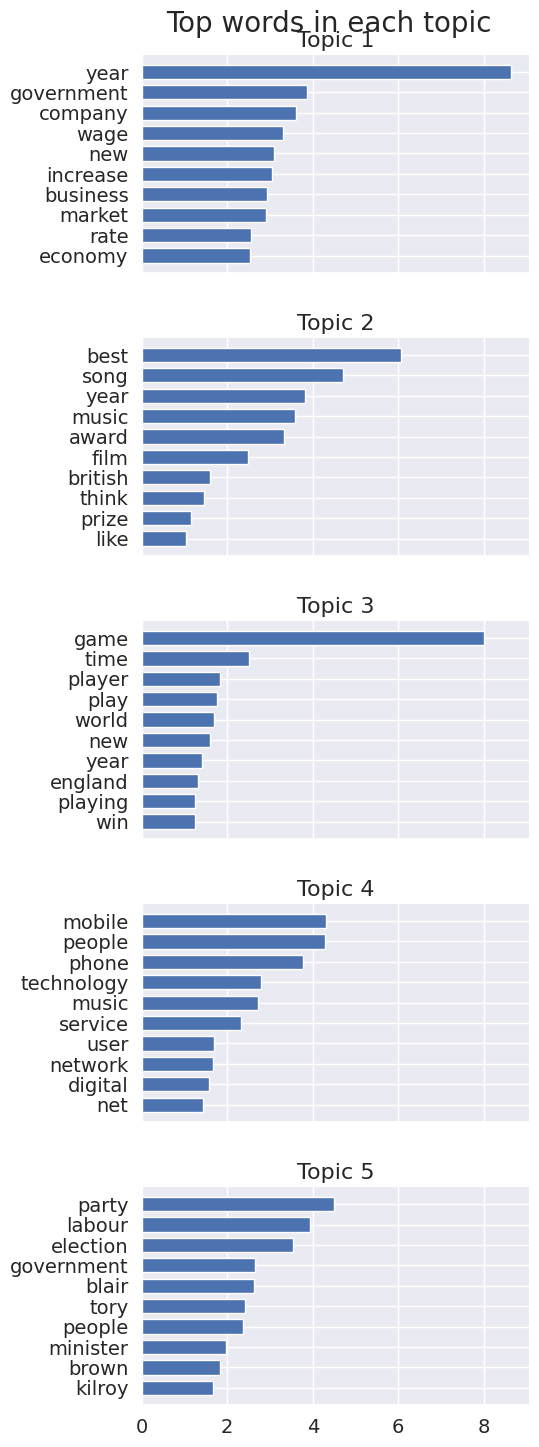

In [163]:
from sklearn.decomposition import NMF

# Assuming document_term_matrix is your document-term matrix obtained from TfidfVectorizer

# Specify the number of topics
num_topics = 5 # You can adjust this as needed

# Initialize NMF model
nmf_model = NMF(n_components=num_topics, random_state=33)

# Fit the model to your document-term matrix
nmf_model.fit(document_term_matrix)

# Get the topic-word matrix
topic_word_matrix = nmf_model.components_

# Get the document-topic matrix
document_topic_matrix = nmf_model.transform(document_term_matrix)

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=model.components_.shape[0], ncols=1, figsize=(5, 3 * model.components_.shape[0]), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

# Assuming nmf_model is your trained NMF model
# Assuming feature_names are the words in your vocabulary obtained from TfidfVectorizer
n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()  # Assuming you have already fitted TfidfVectorizer
plot_top_words(nmf_model, feature_names, n_top_words)

**Count-LSA(SVD)**

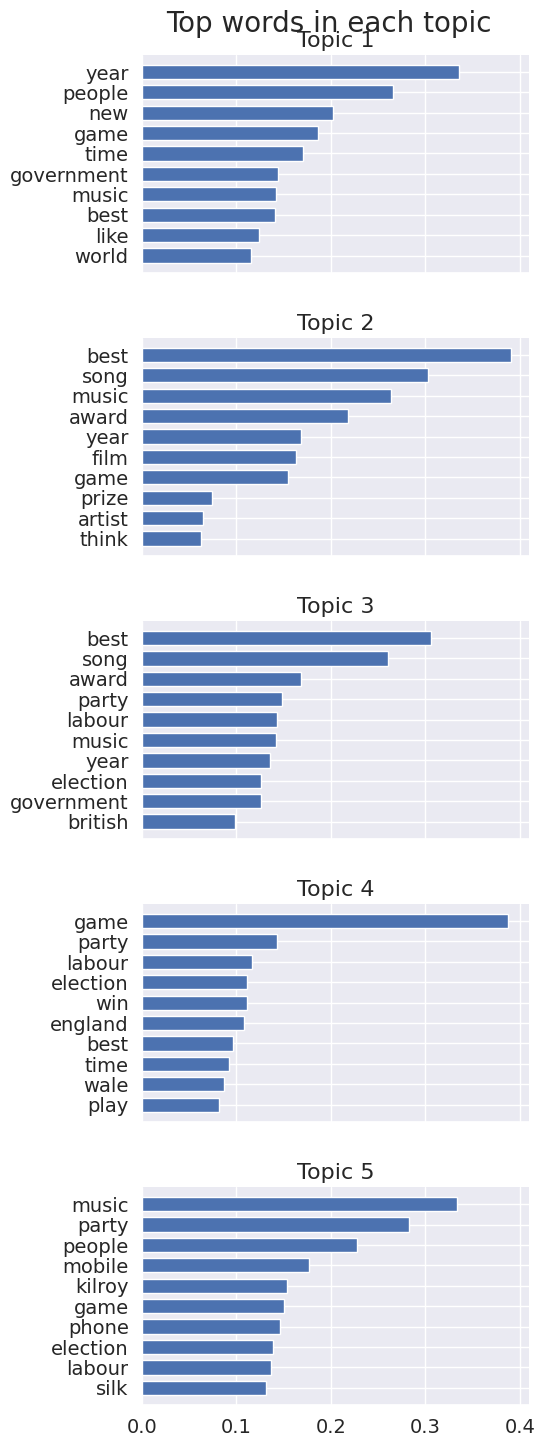

In [155]:
from sklearn.decomposition import TruncatedSVD

# Assuming document_term_matrix is your document-term matrix obtained from TfidfVectorizer

# Specify the number of topics
num_topics = 5  # You can adjust this as needed

# Initialize LSA model with SVD
lsa_model = TruncatedSVD(n_components=num_topics, random_state=33)

# Fit the model to your document-term matrix
lsa_model.fit(document_term_matrix)

# Get the topic-word matrix
topic_word_matrix = lsa_model.components_

# Get the document-topic matrix
document_topic_matrix = lsa_model.transform(document_term_matrix)

# Now you have obtained the topic-word matrix and document-topic matrix

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(nrows=model.components_.shape[0], ncols=1, figsize=(5, 3 * model.components_.shape[0]), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words in each topic', fontsize=20)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()

# Assuming lsa_model is your trained LSA model
# Assuming feature_names are the words in your vocabulary obtained from TfidfVectorizer
n_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()  # Assuming you have already fitted TfidfVectorizer
plot_top_words(lsa_model, feature_names, n_top_words)